In [154]:
from dotenv import load_dotenv
import os
import json
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr

load_dotenv(dotenv_path="./.env")
KAGGLE_USERNAME = os.environ.get("KAGGLE_USERNAME", "")
KAGGLE_KEY = os.environ.get("KAGGLE_KEY", "")
RAW_DATA_PATH = os.environ.get("RAW_DATA_PATH", "")

In [155]:
submission_data = pd.read_csv(RAW_DATA_PATH + "//sample_submission.csv")
test_data = pd.read_csv(RAW_DATA_PATH + "//test.csv")
train_data = pd.read_csv(RAW_DATA_PATH + "//train.csv")

# Short overview

In [192]:
def calc_no_of_outlier(input_values):
    
    input_values = input_values.astype("float")
    
    q_1 = np.quantile(input_values, 0.25)
    q_3 = np.quantile(input_values, 0.75)
    IQR = q_3 - q_1
    upper_limit = q_3 + IQR * 1.5
    lower_limit = q_1 - IQR * 1.5
    
    mask = ((input_values > upper_limit)|(input_values < lower_limit))
    outlier = np.where(mask, input_values, "outlier")     
    
    return outlier

In [201]:
train_data.dtypes

id                         int64
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
outcome                   object
dtype: object

In [209]:
relevant_cols = ["feat", "dtype", "count", "N/A", "nunique", "outliers"]
df_info = pd.DataFrame(columns = relevant_cols)
agg_data = np.array(relevant_cols)

for col in train_data.columns.to_list():
    data = np.array([])
    data = np.append(data, col)
    data = np.append(data, train_data[col].dtype)
    data = np.append(data, train_data[col].shape[0])
    data = np.append(data, train_data[col].isnull().sum())
    data = np.append(data, train_data[col].nunique())
    if train_data[col].dtype=="object":
        data = np.append(data, "xxx")
    else:
        data = np.append(data, len(set(calc_no_of_outlier(train_data[col].values))))
    
    agg_data = np.vstack((agg_data, data))
    
df_info = pd.DataFrame(agg_data).iloc[1:].rename({k:v for k, v in enumerate(relevant_cols)}, axis = 1)

df_info.sort_values(by="dtype")

,feat,dtype,count,N/A,nunique,outliers
1,id,int64,1235,0,1235,1
27,lesion_3,int64,1235,0,2,2
26,lesion_2,int64,1235,0,4,4
4,hospital_number,int64,1235,0,255,30
25,lesion_1,int64,1235,0,57,26
5,rectal_temp,float64,1235,0,43,11
6,pulse,float64,1235,0,50,2
7,respiratory_rate,float64,1235,0,37,9
23,abdomo_protein,float64,1235,0,54,6
21,total_protein,float64,1235,0,83,34


In [157]:
numerical_feats = [feat for feat in df_info[df_info["dtype"]!="object"]["feat"] if (feat in df_info[df_info["dtype"]!="object"]["feat"].values and feat not in ["id"])]
categorical_feats = [feat for feat in df_info["feat"] if (feat not in numerical_feats and not feat in ["id"])]

# First Look

## Categorical data

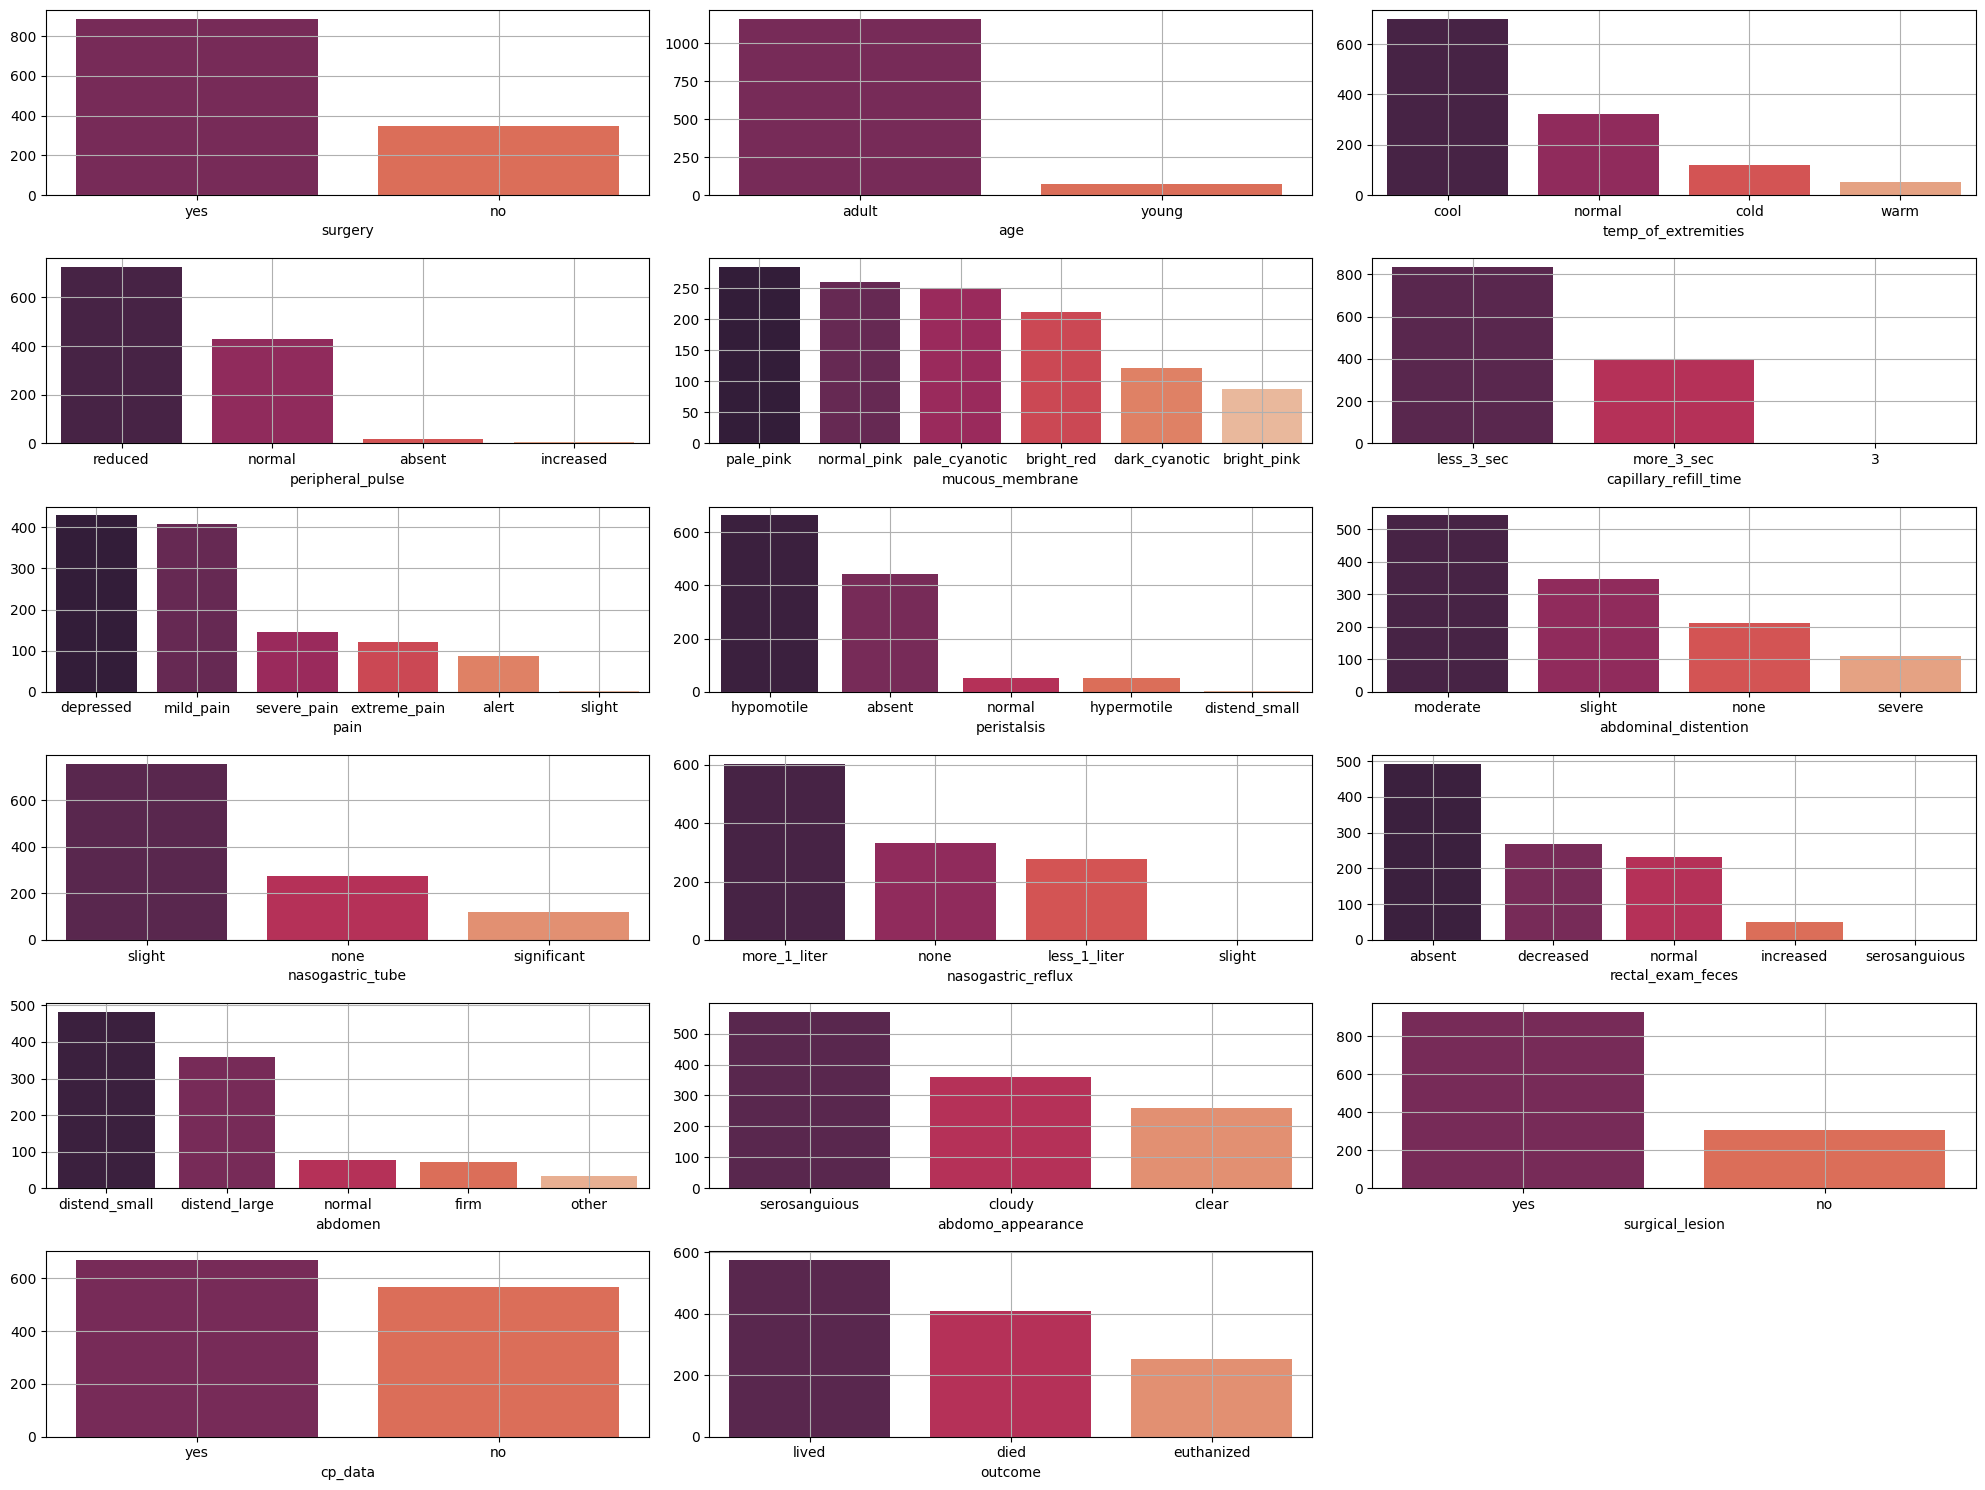

In [158]:
fig, sub = plt.subplots(6,3,figsize=(20,15))
sub_arr = sub.flatten()
feats = df_info[df_info["dtype"] == "object"]["feat"].values

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(categorical_feats):
        tmp_data = train_data[categorical_feats[i]].value_counts()    
        sns.barplot(
            x = tmp_data.index,
            y = tmp_data.values,
            ax = sub_plot,
            palette = "rocket",
        )
        
        sub_plot.grid()        
            
    else:
        sub_plot.set_visible(False)
        
    
fig.tight_layout()    
    

* **surgery:** has the horse been operated?
* **age:** is the horse young / adult?
* **temp_of_extremities:** which temperature has the horse?
* **peripheral_pulse:** Pulse of the horse?
* **mucous_membrane:** Color of the tooth gums?
* **capillary_refill_time:** How long does it take to refill the gums after pressing on it, with blood (sign 
of dehydration)
* **pain:** categorical description of the pain the horse is exposed to
* **peristalsis:** How are the muscles for the transport of food working? 
* **abdominal_distention:** Abdominal sweeling 
* **abdomen:** Status of the abdomen
* **abdomo_appearance:** Appearance of the abdomen
* **surgical_lesion:** Wound of surgical operation
* **cp_data:** ???
* **Outcome:** Fate of the horse (=>died, euthanized or survived)

## Numerical

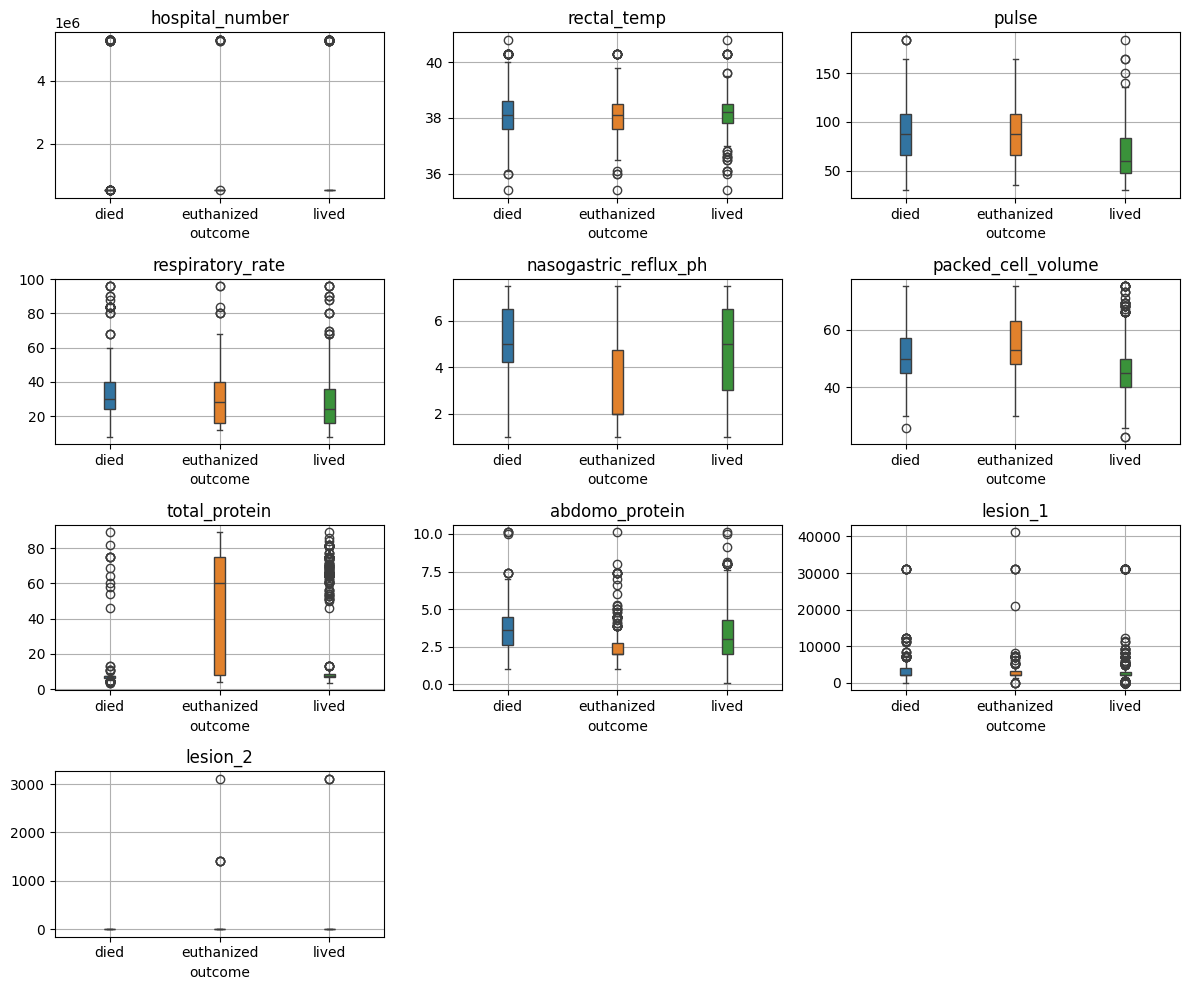

In [170]:
fig, sub = plt.subplots(4,3,figsize=(12, 10))
sub_arr = sub.flatten()

for i, sub_plot in enumerate(sub_arr):
     
    if i<len(numerical_feats[:-1]):
        tmp_data = train_data[[numerical_feats[i], "outcome"]]    
        tmp_data_pivot = pd.pivot(data=tmp_data, columns="outcome", values=numerical_feats[i])
        sns.boxplot(
            data=tmp_data_pivot,
            ax = sub_plot,
            width = 0.1,
        )
        sub_plot.grid()
        sub_plot.set_title(f"{numerical_feats[i]}")
            
    else:
        sub_plot.set_visible(False)
        
    
fig.tight_layout()   

* **rectal_temp:** Temperature measured in the after
* **pulse:** Pulse measured
* **respiratory_rate:** at which rate is the horse's respiration
* **Nasogastric reflux ph:** PH value of the horse's reflux
* **packed_cell_volume:** vol of the horse's cells
* **total_protein:** ???
* **abdomo_protein:** ???
* **lesion 1-3:** ???

# Correlation Analysis

### Numerical Features

<Axes: >

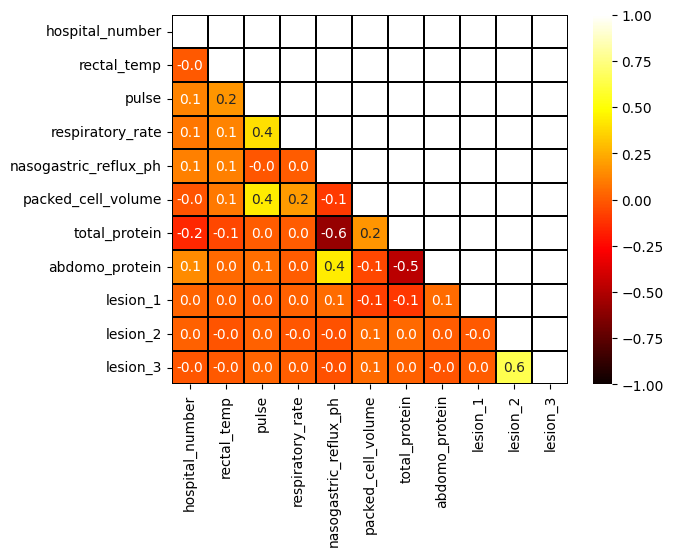

In [160]:
up_triang = np.triu(np.ones_like(train_data[numerical_feats].corr())).astype(bool)

sns.heatmap(
    train_data[numerical_feats].corr(),
    linewidth=0.1,
    linecolor="black",
    robust=True,
    mask=up_triang,
    vmin=-1,
    vmax=1,
    cmap='hot',
    annot=True,
    fmt=".1f"
    )

In [161]:
numerical_correlation = np.array([])

for x in numerical_feats: 
    
    for y in numerical_feats:
        
        corr_result = pearsonr(train_data[x], train_data[y])
        corr_coeff = np.round(corr_result[0], 2)
        p_value = np.round(corr_result[1], 2)
        
        tmp_arr = np.array([x, y, corr_coeff, p_value])
        
        if len(numerical_correlation)==0:
            numerical_correlation = tmp_arr
        else:
            numerical_correlation = np.vstack([numerical_correlation, tmp_arr])

corr_table = pd.DataFrame(numerical_correlation, columns = ["Feat_1", "Feat_2", "Corr_Coeff", "P_value"])  
corr_table["P_value"] = corr_table["P_value"].astype("float")

corr_table[corr_table["P_value"]<0.05]        

,Feat_1,Feat_2,Corr_Coeff,P_value
0,hospital_number,hospital_number,1.0,0.00
2,hospital_number,pulse,0.12,0.00
3,hospital_number,respiratory_rate,0.09,0.00
4,hospital_number,nasogastric_reflux_ph,0.11,0.00
6,hospital_number,total_protein,-0.15,0.00
7,hospital_number,abdomo_protein,0.14,0.00
12,rectal_temp,rectal_temp,1.0,0.00
13,rectal_temp,pulse,0.18,0.00
14,rectal_temp,respiratory_rate,0.12,0.00
15,rectal_temp,nasogastric_reflux_ph,0.12,0.00


### Categorical Features

In [162]:
X = train_data[categorical_feats].drop("outcome", axis = 1).astype("category")
X = X.apply(lambda x: x.cat.codes)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

y = train_data["outcome"].astype("category")

In [163]:
selection = SelectKBest(score_func=chi2, k = "all")

selection.fit(X_scaled, y)

chi2_result = pd.DataFrame({
    "variable": X_scaled.columns,
    "chi2_stat": selection.scores_,
    "p_value": selection.pvalues_}).sort_values(by="p_value", ascending = True)

chi2_result

,variable,chi2_stat,p_value
1,age,51.999358,5.110729e-12
15,cp_data,36.687580,1.079924e-08
14,surgical_lesion,22.352114,1.400555e-05
13,abdomo_appearance,13.754890,1.030774e-03
7,peristalsis,12.423932,2.005291e-03
11,rectal_exam_feces,10.323541,5.731542e-03
0,surgery,8.919798,1.156353e-02
12,abdomen,6.936575,3.117036e-02
2,temp_of_extremities,6.289933,4.306838e-02
8,abdominal_distention,6.230035,4.437773e-02


In [167]:
chi2_result["p_value"] = chi2_result["p_value"].astype("float")
relevant_features = chi2_result[chi2_result["p_value"]<0.05]["variable"].values

In [169]:
categorical_correlation = np.array([])

for feat in relevant_features:
    
    cont_table = pd.crosstab(index = train_data[feat], columns = train_data["outcome"])
    X2_result = scs.chi2_contingency(cont_table)[0]
    N = len(train_data)
    degrees_of_freedom = min(cont_table.shape)-1
    result = np.sqrt((X2_result/N)/degrees_of_freedom)
    
    tmp_arr = np.array([feat, np.round(result, 2), degrees_of_freedom])
    
    if len(categorical_correlation)==0:
        categorical_correlation = tmp_arr
    else:
        categorical_correlation = np.vstack([categorical_correlation, tmp_arr])
        
categorical_correlation = pd.DataFrame(categorical_correlation, columns = ["Features", "Correlation", "df"]).sort_values(by="Correlation", ascending = False)

categorical_correlation

,Features,Correlation,df
2,surgical_lesion,0.27,1
3,abdomo_appearance,0.26,2
1,cp_data,0.25,1
8,temp_of_extremities,0.24,2
4,peristalsis,0.23,2
9,abdominal_distention,0.23,2
0,age,0.21,1
7,abdomen,0.18,2
5,rectal_exam_feces,0.16,2
6,surgery,0.16,1


## XXXX

In [ ]:
#Variance, redundant
#Check Random Forest + Feat importance
# 

In [171]:
train_data

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived
